In [1]:
# data management
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from Utils import downcast, pd_col_to_dummy
from datetime import datetime

from pathlib import Path
from multilayer_perceptron import MultilayerPerceptron

# Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

# logistic regression
from sklearn.linear_model import LogisticRegression

# model selection
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (
    recall_score, 
    precision_score,
    f1_score,
    confusion_matrix
)

# Plot
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# ruta = ("/content/drive/MyDrive/Proyecto_IDI2/Reporte de Anticipos.xlsx")

### 1. Load data

In [4]:
df = pd.read_csv('Reporte de Anticipo Propuesta.csv')

In [5]:
df = downcast(df)

### 2.0 Standardize the data

In [6]:
df_continuous = df.drop(["Gender", "BirthState", "State_Id", "Paid"], axis=1)

### 3.0 Test models

#### 3.1 Split the data into train and test sets

In [7]:
y = df.Paid

In [8]:
# Splitting to training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    df_continuous, y, test_size = 0.3, random_state = 4, stratify = y
)

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [9]:
# The following combinations will be tested
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
def FPR(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

#### 3.2 Bayesian Optimization function

- MultilayerPerceptron

In [45]:
def Mp_bas(neurons, learning_rate=1.25, threshold=0.6, test_size=0.3, random_state=4):

    X_train_ = X_train.copy()
    X_test_ = X_test.copy()

        
    ###############################	
    # fit and predict
    ###############################

    # parameters
    hyperparameters = {
        "n_neurons": int(neurons),
        "eta": learning_rate,
        "threshold": threshold,
        "random_state": 4,
    }

    model = MultilayerPerceptron(**hyperparameters).fit(X_train_, y_train)

    y_pred_prob = model.predict(X_test_, prob=True)

    y_pred = model.predict(X_test_, prob=False)

    y_pred_train = model.predict(X_train_, prob=False)
    
    ###############################	
    # compute metrics
    ###############################
    fpr = FPR(y_test, y_pred)
    recall_ = 1 - recall_score(y_test, y_pred)
    precision_score_ = precision_score(y_test, y_pred)

    # distance to 0.5
    dist = np.mean(np.sin(y_pred_prob*np.pi))

    ###############################	
    # print results
    ###############################
    print(f"loss: {fpr*10 + dist*100 + recall_*2}")

    print(f"FPR: {fpr}, distance to 0.5: {dist}, recall complement: {recall_}")

    print(f"precision_score: {precision_score_}")

    print("Conjunto de prueba: ")

    (
        pd
        .DataFrame(confusion_matrix(y_test, y_pred))
        .style.background_gradient(cmap='Oranges')
        .set_caption('Conjunto de prueba: ')
        .pipe(display)
    )

    print("Conjunto de entrenamiento: ")

    (
        pd
        .DataFrame(confusion_matrix(y_train, y_pred_train))
        .style.background_gradient(cmap='Blues')
        .set_caption('Conjunto de entrenamiento: ')
        .pipe(display)
    )

    
    return y_pred_prob

- LogisticRegression

In [46]:
def Lr_bas(gender=0, State=0, BState=0, threshold=0.6, test_size=0.3, random_state=4):

    X_train_ = X_train.copy()
    X_test_ = X_test.copy()

        
    ###############################	
    # fit and predict
    ###############################

    model = LogisticRegression(random_state=random_state).fit(X_train_, y_train.reshape(-1))

    y_pred_prob = model.predict_proba(X_test_)[:, 1].reshape(-1, 1)

    y_pred = np.where(y_pred_prob > threshold, 1, 0)

    y_pred_train = model.predict(X_train_).reshape(-1, 1)
    
    ###############################	
    # compute metrics
    ###############################

    fpr = FPR(y_test, y_pred)
    recall_ = 1 - recall_score(y_test, y_pred)
    precision_score_ = precision_score(y_test, y_pred)

    # distance to 0.5
    dist = np.mean(np.sin(y_pred_prob*np.pi))

    ###############################	
    # print results
    ###############################
    
    print(f"loss: {fpr*10 + dist*100 + recall_*2}")

    print(f"FPR: {fpr}, distance to 0.5: {dist}, recall complement: {recall_}")

    print(f"precision_score: {precision_score_}")

    print("Conjunto de prueba: ")

    (
        pd
        .DataFrame(confusion_matrix(y_test, y_pred))
        .style.background_gradient(cmap='Oranges')
        .set_caption('Conjunto de prueba: ')
        .pipe(display)
    )

    print("Conjunto de entrenamiento: ")

    (
        pd
        .DataFrame(confusion_matrix(y_train, y_pred_train))
        .style.background_gradient(cmap='Blues')
        .set_caption('Conjunto de entrenamiento: ')
        .pipe(display)
    )
    
    
    
    return y_pred_prob

#### 3.3 Optimal Model comparison

- LogisticRegression

In [44]:
y_lr = Lr_bas(BState=0, gender=0, State=0, threshold=0.8)

loss: 2.9689180791186613
FPR: 0.11320754716981132, distance to 0.5: 0.018267940973720375, recall complement: 0.005024255024255075
precision_score: 0.9968755424405485
Conjunto de prueba: 


,0,1
0,141,18
1,29,5743


Conjunto de entrenamiento: 


,0,1
0,295,77
1,26,13440


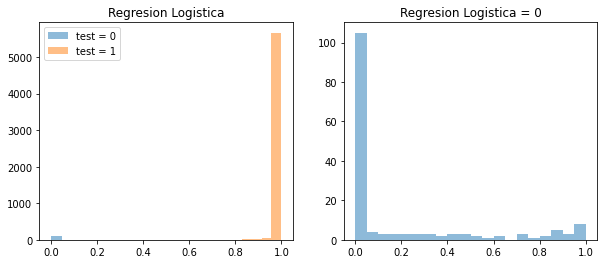

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(y_lr[y_test == 0], bins=20, alpha=0.5, label="test = 0")
ax[0].hist(y_lr[y_test == 1], bins=20, alpha=0.5, label="test = 1")
ax[0].set_title("Regresion Logistica")
ax[0].legend()
ax[1].hist(y_lr[y_test == 0], bins=20, alpha=0.5, label="test = 0")
ax[1].set_title("Regresion Logistica = 0");


- MultilayerPerceptron

In [47]:
y_mp = Mp_bas(neurons=66, learning_rate=1.25, threshold=0.8)

loss: 1.5576721245374463
FPR: 0.07547169811320754, distance to 0.5: 0.00794985635435863, recall complement: 0.003984753984753953
precision_score: 0.997917028293699
Conjunto de prueba: 


,0,1
0,147,12
1,23,5749


Conjunto de entrenamiento: 


,0,1
0,337,35
1,49,13417


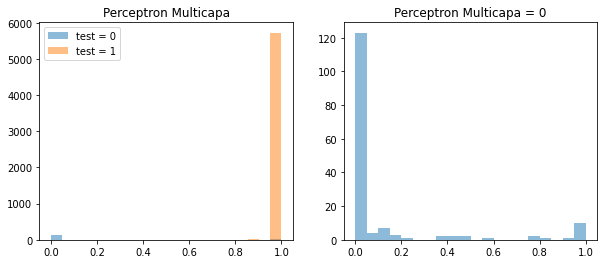

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(y_mp[y_test == 0], bins=20, alpha=0.5, label="test = 0")
ax[0].hist(y_mp[y_test == 1], bins=20, alpha=0.5, label="test = 1")
ax[0].set_title("Perceptron Multicapa")
ax[0].legend()
ax[1].hist(y_mp[y_test == 0], bins=20, alpha=0.5, label="test = 0")
ax[1].set_title("Perceptron Multicapa = 0");

In [17]:
# another good example
y_mp = Mp_bas(neurons=35, learning_rate=1.25, threshold=0.8);

loss: 2.152415386393361
FPR: 0.06289308176100629, distance to 0.5: 0.015127430580417874, recall complement: 0.005370755370755376
precision_score: 0.9982611719700921
Test set: 


,0,1
0,149,10
1,31,5741


Train set: 


,0,1
0,338,34
1,68,13398
